# LDA Model Analysis Notebook

Intro: This notebook contains a detailed analysis of a LDA model, chosen by it's coherence score.

In [1]:
import itertools
import numpy as np
import datetime
import os
import pandas as pd
import time
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import logging
from gensim.test.utils import datapath
from gensim import models
from gensim.models import CoherenceModel
import plotly.express as px

In [2]:
best_model = str(1693294471)
model_filepath = f"{best_model}/model"
doc_mappings_filepath = f"{best_model}/docs_topics.csv"
topics_mapping_filepath = f"{best_model}/topics.xlsx"
hugging_face_filepath = "my-dataset-train.csv"

### Loading model object + documents mappings

In [3]:
model = models.ldamodel.LdaModel.load(model_filepath)
doc_mappings = pd.read_csv(doc_mappings_filepath)
topic_mappings = pd.read_excel(topics_mapping_filepath)

In [4]:
yr_mapping_dir = r"C:\Users\noabi\OneDrive\שולחן העבודה\university\Year 3\project"
yr_mapping = pd.read_excel("extract_years_1693237369.xlsx")

### Topics Mappings


In [5]:
topic_mappings.head(100)
topic_num = topic_mappings.shape[0]
print(f"Topics Number: {topic_num}")

Topics Number: 25


### Joining topic mappings with data
First cleaning filenmae column so data can be joined

In [6]:
merged_df = yr_mapping.merge(doc_mappings, on = ["filename"])
merged_df["StrongestTopic"] = merged_df.iloc[:,-topic_num:].idxmax(axis=1)
merged_df["Year"] = merged_df["max_year"].astype(int)
merged_df.rename(columns= {"Unnamed: 0_x" : "index"}, inplace=True)

In [40]:
# aggregated data
yr_agg_df = merged_df.groupby(["Year", "StrongestTopic"])["index"].count().reset_index().rename(columns={"index" : "Verdicts"})
yr_stats_df = merged_df.groupby(["Year"])["index"].count().reset_index().rename(columns = {"index" : "overall_verdicts"})
yr_agg_df = yr_agg_df.merge(yr_stats_df, on = "Year")
yr_agg_df["topic_percentages"] = yr_agg_df["Verdicts"] * 100.0 / yr_agg_df["overall_verdicts"]

### Trend Analysis

In [39]:
filtered_data  = yr_agg_df[yr_agg_df.Year>1970]
px.line(filtered_data,x="Year",y="topic_percentages",color="StrongestTopic", title = "Topics Trend Per Years",
       labels = {"topic_percentages" : "Topic Volume (%)"})

In [10]:
yr_agg_df["StrongestTopic"] = yr_agg_df["StrongestTopic"].astype(int) 
agg_df = yr_agg_df.groupby(["StrongestTopic"])["Verdicts"].sum().reset_index()
fig = px.bar(agg_df, x='StrongestTopic', y='Verdicts', title = "Topics Histogram Overall Years")
fig.show()

In [53]:
print("Topics and their words")
model.print_topics(num_words=20)

Topics and their words


[(21,
  '0.023*"עבירה" + 0.017*"פלילי" + 0.015*"עונש" + 0.014*"אסיר" + 0.014*"מאסר" + 0.013*"שיקול" + 0.011*"אישום" + 0.010*"צבאי" + 0.010*"משפטי" + 0.010*"סוהר" + 0.008*"שחרור" + 0.008*"מעשה" + 0.008*"עבירות" + 0.007*"חסינות" + 0.007*"סמכות" + 0.007*"יועץ" + 0.007*"סעיף" + 0.007*"כתב" + 0.007*"הורשע" + 0.007*"נאשם"'),
 (13,
  '0.031*"רישיון" + 0.025*"סמכות" + 0.018*"תקנה" + 0.016*"עסק" + 0.015*"שר" + 0.013*"סעיף" + 0.011*"מנהלי" + 0.010*"בעל" + 0.009*"שיקול" + 0.008*"רישוי" + 0.008*"תחבורה" + 0.008*"משרד" + 0.008*"רכב" + 0.008*"עיסוק" + 0.008*"פיקוח" + 0.006*"הוראה" + 0.006*"נתן" + 0.006*"הוסמך" + 0.005*"הפעלה" + 0.005*"רשאי"'),
 (4,
  '0.036*"ילד" + 0.026*"מעצר" + 0.023*"קטין" + 0.017*"הורה" + 0.013*"משמורת" + 0.013*"נכה" + 0.011*"רפואי" + 0.010*"משפחה" + 0.010*"נכות" + 0.010*"לאומי" + 0.009*"ביטוח" + 0.008*"תגמול" + 0.007*"תקופה" + 0.007*"נפגע" + 0.007*"אב" + 0.006*"חווה" + 0.006*"מוסד" + 0.006*"זכות" + 0.006*"ועדה" + 0.006*"סעיף"'),
 (0,
  '0.034*"חקירה" + 0.024*"משטרה" + 0.013*"חו

# Visualization

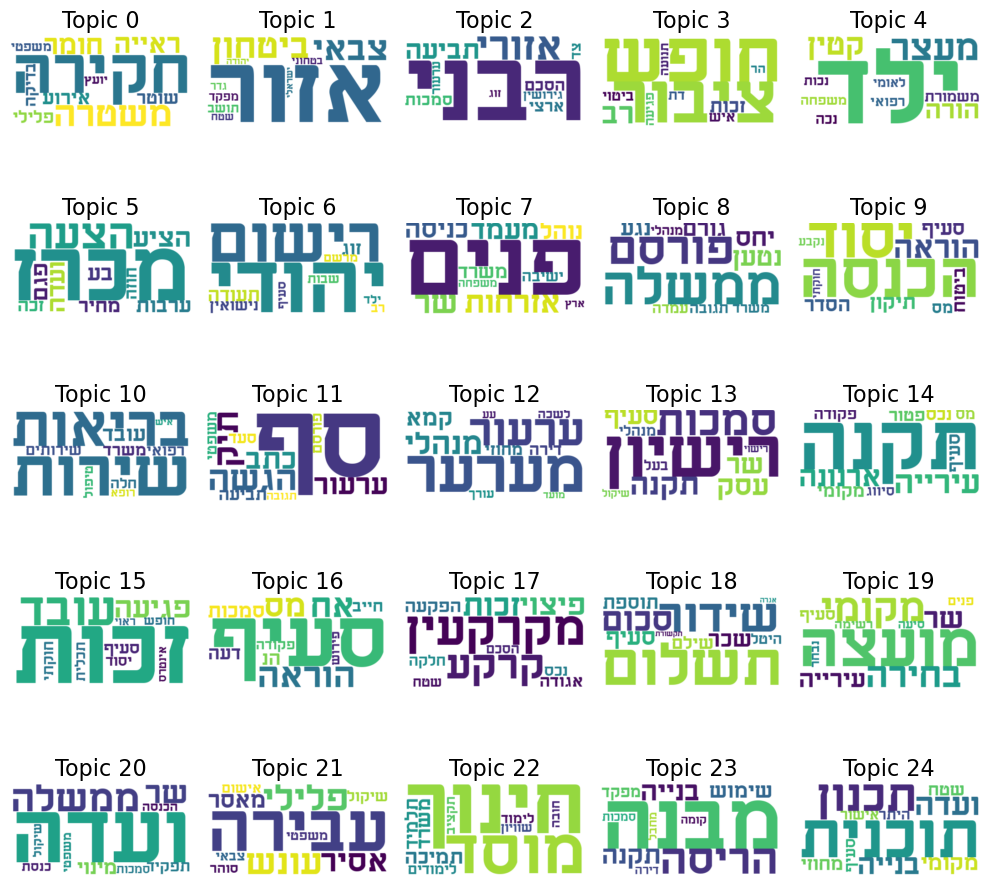

In [48]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from bidi.algorithm import get_display
import math


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(font_path='C:/Windows/Fonts/ahronbd.ttf', background_color='white')
n_topics = model.get_topics().shape[0]
topics = model.show_topics(formatted=False, num_topics = n_topics)
sqrt_topics = int(math.ceil(n_topics ** 0.5))

fig, axes = plt.subplots(sqrt_topics, sqrt_topics, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    if i >= n_topics:
        continue
    topic_words = dict(topics[i][1])
    new_topic_words = dict()
    for key, val in topic_words.items():
        new_topic_words[key[::-1]] = val
    cloud.generate_from_frequencies(new_topic_words, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f"model_{best_model}_word_cloud.jpeg")
plt.show()